In [74]:
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

In [14]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
TITLE_FONT_SIZE = 14
AXIS_FONT_SIZE = 12

In [5]:
W = np.array([
    [0, 1, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0]
])

D = np.diag(np.sum(W, axis=0))

In [6]:
def alr(theta):
    return np.log(theta[:-1] / theta[-1])

def inv_alr(x):
    theta = np.concatenate([np.exp(x), np.array([1.0])])
    return theta / np.sum(theta)

In [7]:
def sample_cov(x, y):
    n = x.size
    return np.sum((x - np.mean(x)) * (y - np.mean(y))) / (n - 1)  

## $\tilde \theta_i \sim N(0, (D - \rho W)^{-1}_{ii} \Sigma)$

In [8]:
def simulate_one_marginal(A, Sigma, i, nsamples):
    dim = Sigma.shape[0]
    draws = np.random.multivariate_normal(mean=np.zeros(dim), cov=A[i, i] * Sigma, size=nsamples)
    return np.apply_along_axis(inv_alr, 1, draws)

In [9]:
rho = 0.9
A = np.linalg.inv(D - rho * W)

In [10]:
corr = -0.9
var = 1
Sigma = np.array([[var, corr], [corr, var]])
draws = simulate_one_marginal(A, Sigma, 1, 10000)

In [21]:
A

array([[1.89655172, 1.55172414, 1.55172414, 0.        , 0.        ],
       [1.55172414, 1.89655172, 1.55172414, 0.        , 0.        ],
       [1.55172414, 1.55172414, 1.89655172, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 5.26315789, 4.73684211],
       [0.        , 0.        , 0.        , 4.73684211, 5.26315789]])

In [19]:
i = 1
var = 1
covs01 = []
covs02 = []
covs12 = []
corrs = np.linspace(-0.99, 0.99, 50)

for corr in corrs:
    Sigma = np.array([[var, corr], [corr, var]])
    draws = simulate_one_marginal(A, Sigma, i, 10000)
    covs01.append(sample_cov(draws[:, 0], draws[:, 1]))
    covs02.append(sample_cov(draws[:, 0], draws[:, 2]))
    covs12.append(sample_cov(draws[:, 0], draws[:, 1]))

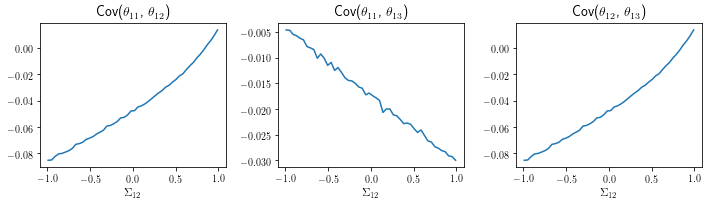

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].plot(corrs, covs01)
axes[0].set_title(r"Cov($\theta_{{{%i}}1}$, $\theta_{{{%i}}2}$)" % (i, i), fontsize=TITLE_FONT_SIZE)
axes[0].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)

axes[1].plot(corrs, covs02)
axes[1].set_title(r"Cov($\theta_{{{%i}}1}$, $\theta_{{{%i}}3}$)" % (i, i), fontsize=TITLE_FONT_SIZE)
axes[1].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)

axes[2].plot(corrs, covs12)
axes[2].set_title(r"Cov($\theta_{{{%i}}2}$, $\theta_{{{%i}}3}$)" % (i, i), fontsize=TITLE_FONT_SIZE)
axes[2].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)

plt.tight_layout()
plt.show()

## $(\tilde \theta_i, \tilde \theta_j)  \sim N(0, (D - \rho W)^{-1}_{(i,j) \times (i, j)}  \otimes \Sigma)$

In [80]:
# This function simulates from the joint marginal distribution
# of (theta_{i}, theta_{j})

def simulate_joint_marginal(A, Sigma, i, j, nsamples):
    dim = Sigma.shape[0]
    cov = np.kron(A[[[i],[j]],[i, j]], Sigma)
    draws = np.random.multivariate_normal(mean=np.zeros(2 * dim), cov=cov, size=nsamples)
    theta_i = np.apply_along_axis(inv_alr, 1, draws[:, :dim])
    theta_j = np.apply_along_axis(inv_alr, 1, draws[:, dim:])
    return theta_i, theta_j

In [57]:
corr = -0.5
Sigma = np.array([[var, corr], [corr, var]])

In [100]:
i = 1
j = 4

corrs = np.linspace(-0.99, 0.99, 50)
covs = defaultdict(list)
for corr in corrs:
    Sigma = np.array([[var, corr], [corr, var]])
    thetas = simulate_joint_marginal(A, Sigma, i, j, 10000)
    
    for l in range(3):
        for m in range(3):
            covs[(l, m)].append(sample_cov(thetas[0][:, l], thetas[1][:, m]))

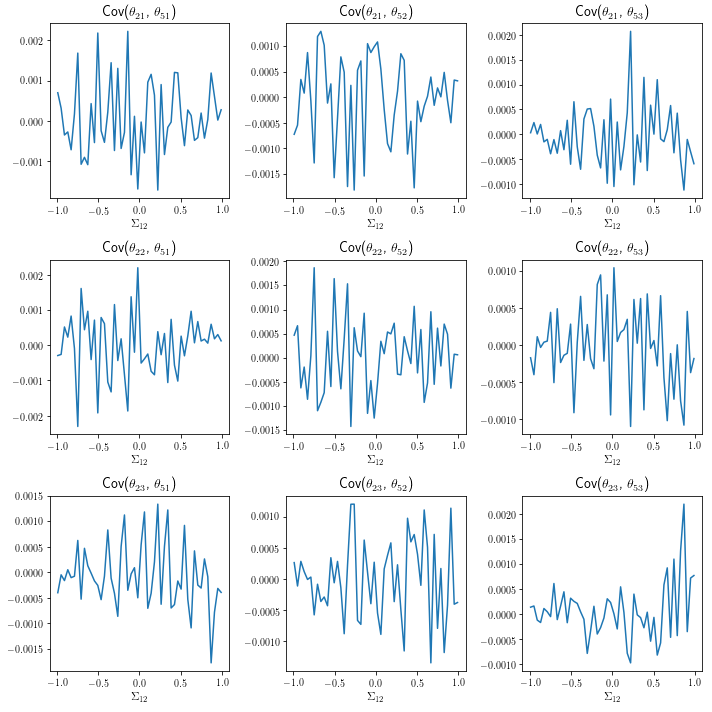

In [101]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for l in range(3):
    for m in range(3):
        axes[l][m].plot(corrs, covs[(l, m)])
        axes[l][m].set_title(r"Cov($\theta_{{{%i}} {{%i}}}$, $\theta_{{{%i}} {{%i}}}$)" % (i+1, l+1, j+1, m+1),
                          fontsize=TITLE_FONT_SIZE)
        axes[l][m].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)


plt.tight_layout()
plt.show()